In [ ]:
# Installation d la bibliothèque d2l, elle sera uniquement utilisée une fois
# pour faciliter l'affichage en temps réel de l'évolution des loss et de
# l'image générée.
!pip install d2l==0.17.0

# Neural Style Transfer

![Style Transfer explanation](https://github.com/imane-C/blob/master/media/style-transfer.svg?raw=1)

## Methode


![Style Transfer Model](https://github.com/imane-C/blob/master/media/neural-style.svg?raw=1)


## **Import des bibliothèques, lecture et affichage des images de contenu et de style**

Dans un premier temps nous ouvrons et affichons les images de contenu et de style. Cela nous permet déjà d'avoir un aperçu de leurs tailles.


In [2]:
# Ces deux lignes permettent d'importer son dossier google drive dans les
# les fichiers accessibles par le notebook.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


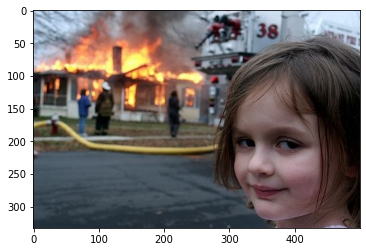

In [3]:
%matplotlib inline
# Import de torch
import torch

# La biblothèque torchvision se compose d'ensembles de données populaires,
# d'architectures de modèles et de transformations d'images courantes pour la
# computer vision
import torchvision

from torch import nn

# PIL est une bibliothèque de traitement d’image. Elle est conçue de manière à
# offrir un accès rapide aux données contenues dans une image, et offre un
# support pour différents formats de fichiers
from PIL import Image

# Matplotlib est une bibliothèque complète permettant de créer des
# visualisations statiques, animées et interactives en Python
import matplotlib.pyplot as plt

# Cette dernière bibliothèque permet un affichage dynamique des images et des
# des courbes de loss. Elle utilise matplotlib.
from d2l import torch as d2l

# Nous renseignons le chemin d'accès à notre image de contenu pour l'ouvrir et
# l'afficher
content_img = Image.open('/content/drive/MyDrive/CONTENT_IMG1.jpg')
plt.imshow(content_img)
plt.show()

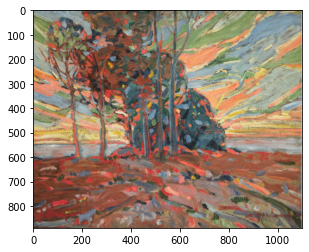

In [4]:
# De la même façon, on ouvre et affiche l'image de style choisi
style_img = Image.open('/content/drive/MyDrive/STYLE_IMG1.jpg')
plt.imshow(style_img)
plt.show()

## **Preprocessing et Postprocessing**

Ci-dessous se trouvent deux fonctions pour le preprocessing et le postprocesing
des images.

La fonction `preprocess` est une pipeline :
1. Elle resize l'image à la taille souhaité par l'utilisateur.
2. Elle transforme les données de l'image en Tensor pour pouvoir travailler avec pytorch ensuite.
3. Elle normalise les channels RGB.

Finalement la fonction passe l'image d'entrée dans cette pipeline puis ajoute une dimension pour être au format du réseau de neurone convolutionel.

La fonction `postprocess` restaure les valeurs des pixel avant leurs normalisations. Elle remplace également chaque pixel ayant une valeur inférieure à 0 ou supérieure à 1 par 0 ou 1. Cela permet ensuite de convertir l'image en image PIL pour l'affichage.

In [5]:
# Valeurs pour la normalisation des channels
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape): 
    """
    img : l'image à faire entrée dans la pipeline
    image_shape : la taille demandée pour l'image

    Retourne un tensor de l'image après passage de la pipeline
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    """
    img : l'image à postprocess

    Retourne une image PIL
    """
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## **Extraction des features**

On utilise le réseau de neurone convolutif VGG19 pré-entrainé sur le dataset Imagenet pour extraire les features des images de contenu et de style.


In [6]:
# On télécharge le model de réseau de neurones convolutif VGG19
pretrained_net = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [7]:
# Affichage du model avec un exemple
from torchsummary import summary
pretrained_net.cuda()
summary(pretrained_net, (3, 300, 450))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 450]           1,792
              ReLU-2         [-1, 64, 300, 450]               0
            Conv2d-3         [-1, 64, 300, 450]          36,928
              ReLU-4         [-1, 64, 300, 450]               0
         MaxPool2d-5         [-1, 64, 150, 225]               0
            Conv2d-6        [-1, 128, 150, 225]          73,856
              ReLU-7        [-1, 128, 150, 225]               0
            Conv2d-8        [-1, 128, 150, 225]         147,584
              ReLU-9        [-1, 128, 150, 225]               0
        MaxPool2d-10         [-1, 128, 75, 112]               0
           Conv2d-11         [-1, 256, 75, 112]         295,168
             ReLU-12         [-1, 256, 75, 112]               0
           Conv2d-13         [-1, 256, 75, 112]         590,080
             ReLU-14         [-1, 256, 

On sélectionne les couches du model VGG19 qui nous intéressent. Plus on extrait les features proches de la couche d'entrée, plus on capture des features détaillées, et vice versa, plus on s'éloigne de la couche d'entrée, plus on capte les informations global de l'image.

C'est pour cela que nous choisissons une couche proche de la sortie du model (la dernière couche de convolution du 4ème bloc de convolution) pour extraire les features de l'image de contenue, afin de capter les informations globales à transférer à l'image généréee.

Pour les couches de style nous sélectionnons chaque premières couches à différents niveaux du modèle (chaques premières couches de convolution des 5 blocs de convolution) pour extraire des informations globales et plus détaillés de l'image de style.

In [8]:
# Indices des couches choisies sur le model VGG19
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

On initialise un model contenant les couches depuis la couche d'entrée jusqu'à la couche la plus profonde que l'on utilise (dans notre exemple il s'agit de la couche 28).

In [9]:
net = nn.Sequential(*[
    pretrained_net.features[i]
    for i in range(max(content_layers + style_layers) + 1)])

La fonction `extract_features` permet de récupérer les features de style et de contenu en récupérant les sorties des couches intermédiaires (listes `style_layers` et `content_layers`) du réseau de neurones VGG19.

In [10]:
def extract_features(X, content_layers, style_layers):
    """
    X : l'image sous forme de tensor
    content_layer : la liste des indices des couches de contenu
    style_layers : la liste des indices des couches de style

    Retourne deux listes 'content' et 'style' contenant les features de contenu
    et de style après passage dans le réseau VGG19
    """
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

Les deux fonctions définies ci-desssous, `get_contents` et `get_styles` de faire passer les images de contenu et de style dans la pipeline de preprocessing pour ensuite extraire les features à l'aide la fonction `extract_features` définie juste avant.

Les features de l'image générée, quand à elles, seront extraites durant l'entrainement.


In [11]:
def get_contents(image_shape, device):
    """
    image_shape : taille de l'image voulu pour le preprocessing
    device : 'cpu' ou 'cuda:0' suivant l'utilisation d'un CPU ou d'un GPU

    Retourne l'image de contenu en Tensor et les features de contenu
    """
    # On passe l'image de contenu dans la pipeline de preprocessing
    content_X = preprocess(content_img, image_shape).to(device)
    # On extrait les features avec la fonction 'extract_features'
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    """
    image_shape : taille de l'image voulu pour le preprocessing
    device : 'cpu' ou 'cuda:0' suivant l'utilisation d'un CPU ou d'un GPU

    Retourne l'image de style en Tensor et les features de style
    """
    # On passe l'image de style dans la pipeline de preprocessing
    style_X = preprocess(style_img, image_shape).to(device)
    # On extrait les features avec la fonction 'extract_features'
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## **Défintion de la fonction de loss**

La fonction de loss du style transfer contient la content loss, la loss de style loss et la total variation loss.

### Content Loss

La fonction de content loss est assez classique, elle calcule la différrence entre l'image de contenu et l'image générée et la met au carré à la manière d'une MSE. Les deux inputs de la fonction square proviennent de l'extraction de features.

In [12]:
def content_loss(Y_hat, Y):
    """
    Y_hat : features de l'image générée
    Y : features de l'image cible

    Retourne un tensor contenant un float qui représente la content loss
    """
    # On détache l'image cible de contenu de l'arbre de backpropagation car
    # c'est une valeur fixe qui ne bougera pas dans le temps et qui n'as pas
    # besoin d'être mise à jour.
    return torch.square(Y_hat - Y.detach()).mean()

### Style Loss
La style loss utilise également la fonction de squared loss pour calculer la différence de style entre l'image générée et l'image de style.
Cependant avant d'utiliser la fonction de squared loss, les features de style de l'image générée et de l'image de style doivent être transformées en *Matrice de Gram*.

Dans un premier temps, prenons l'exemple d'une sortie de la fonction `extract_features` de la taille suivante : 

<center> $C$ channels, une hauteur $H$ et une largeur $L$ </center>

on peut transformer cette matrice en une nouvelle matrice de taille (*$C$*, *$H$* * *$L$*). C'est à dire une matrice avec *$C$* lignes et *$H$* * *$L$* colonnes.

Par exemple pour une matrice de 3 channels chaque ligne de la matrice $\mathbf{x}_1$, $\mathbf{x}_2$ et $\mathbf{x}_3$ représentent un channel.

La matrice de Gram  $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$ est le produit matricielle de X par sa transposée $\mathbf{X}^\top$. Elle  représente la correlation entre les différents channels. En effet chaque éléments $x_{ij}$ de ligne $i$ et de colonne $j$ est par conséquent le produit scalaire de $\mathbf{x}_i$ et $\mathbf{x}_j$.

Pour éviter que les vecteurs de la matrice de Gram ne soit influencées par la taille de *$H*L$* la fonction `gram` ci-dessous divise la matrice Gram par le nombre d'éléments qu'elle contient.

In [13]:
def gram(X):
    """
    X : la matrice à passer en matrice Gram

    Retourne la matrice Gram
    """
    # On récupère le nombre de channel ainsi que le nombre d'élements par channel
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    # On reshape notre matrice avec ces deux valeurs
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

Ici on assume que la matrice gram de l'image de style `gram_Y` est calculée au préalable.

In [14]:
def style_loss(Y_hat, gram_Y):
    """
    Y_hat : les features style de l'image générée
    gram_Y : la matrice gram de l'image style (doit être précalculé)

    Retourne un tensor contenant un float qui représente la style loss
    """
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### Total Variation Loss

La Total Variation Loss est une fonction de loss qui n'est pas toujours présente en style transfer. Elle permet de réduire les bruits à hautes fréquences (pixels particulièrement sombre ou clair) qui peuvent être générée dans l'image de sortie.

La méthode choisi pour réduire ce bruit est la suivante :

$x_{i, j}$ étant la valeur du pixel aux coordonnées $(i, j)$.
Réduire la loss de variation totale

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

permet de faire en sorte que les valeurs des pixels voisins soient plus proches.


In [21]:
def tv_loss(Y_hat):
    """
    Y_hat : l'image générée

    Retourne tensor contenant un float
    """    
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### Fonction de loss

**Au final, la fonction de loss en style transfer est la somme pondérée de la content loss, la style loss, et la total variation loss**.

En jouant sur ces poids, on peut décider d'avoir une image avec un style très présent, laisser plus d'importance au contenu et réduire plus ou moins le bruit sur l'image générée.

In [22]:
# Initialisation des poids des fonctions de loss
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    """
    X : image d'entrée
    contents_Y_hat : features de contenu de l'image générée
    styles_Y_hat : features de style de l'image générée
    contents_Y : features de contenu de l'image contenu
    styles_Y_gram : matrice gram des features de l'image de style

    Retourne les loss de contenu, de style, de total variation et la loss totale
    """
    # Calcul de la content loss
    contents_l = [
        content_loss(Y_hat, Y) * content_weight
        for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    # Calcul de la style loss
    styles_l = [
        style_loss(Y_hat, Y) * style_weight
        for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    # Calcul de la total variation loss
    tv_l = tv_loss(X) * tv_weight
    # On additionne les 3 loss
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## **Initialisation de l'image à générer**

La class suivante `SynthesizedImage` nous permet de définir un modèle et de traiter l'image générée comme étant les paramètres du modèle à mettre à jour.

In [24]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        # On initialise les poids de façon aléatoire avec la taille de notre image
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        """
        La forward propagation retourne les poids du model
        """
        return self.weight

La fonction `get_inits` crér une instance de la class `SynthesizedImage` et l'initialise avec l'image `X`.
C'est ici que l'on initialise la matrice Gram de l'image de style.


In [25]:
def get_inits(X, device, lr, styles_Y):
    """
    X : Image contenu d'entrée 
    device : 'cpu' ou 'cuda:0' suivant l'utilisation d'un CPU ou d'un GPU
    lr : learning rate
    styles_Y : features de l'image style

    Retourne une instance de SynthesizedImage, la matrice Gram de l'image de
    style et l'optimiseur
    """
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    # On initialise l'optimiseur avec le learning rate choisi
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    # On crée la matrice Gram de l'image de style
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## **Entrainement**

Pendant l'entrainement, à chaque epoch, on extrait les features de style et de contenu de l'image générée et on calcule la fonction loss.

In [28]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    """
    X : Image contenue d'entrée
    contents_Y : features de l'image contents
    styles_Y: features de l'image style
    device : 'cpu' ou 'cuda:0' suivant l'utilisation d'un CPU ou d'un GPU
    lr : learning rate
    num_epochs : nombre d'epochs
    lr_decay_epoch : Période de réduction du learning rate

    Retourne l'image générée
    """
    # on initialise avec l'image X, on crée la matice Gram de l'image style et
    # l'optimiseur
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    # Le scheduler va gérer la diminution progressive du learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    # Affichage dynamique de l'évolution des loss et de l'image de sortie
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style',
                                    'TV'], ncols=2, figsize=(7, 2.5))
    # Entrainement, pour chaque epoch :
    for epoch in range(num_epochs):
        # On remet à zero les gradients
        trainer.zero_grad()
        # On extrait les features de l'image générée
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        # Calcul de la loss
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat,
                                                     styles_Y_hat, contents_Y,
                                                     styles_Y_gram)
        # Backpropagation
        l.backward()
        # On fait un pas avec l'optimiseur et le scheduleur
        trainer.step()
        scheduler.step()

        # On affiche de façon régulière l'évolution des loss et de l'image de sortie
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(
                epoch + 1,
                [float(sum(contents_l)),
                 float(sum(styles_l)),
                 float(tv_l)])
    return X

Now we [**start to train the model**].
We rescale the height and width of the content and style images to 300 by 450 pixels.
We use the content image to initialize the synthesized image.


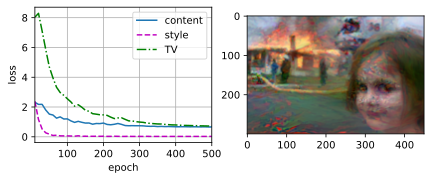

In [29]:
# On test si l'appareil qui fait tourner le code possède un GPU, 
# si c'est le cas on défini le device sur gpu sinon sur CPU
num_gpus = torch.cuda.device_count()
if num_gpus >= 1:
  device = torch.device("cuda:0")
else:
  device = torch.device('cpu')

# On choisi la taille de l'image que l'on souhaite générer
image_shape = (300,450)

net = net.to(device)
# On récupère l'image de contenu après le preprocessing et ses features
content_X, contents_Y = get_contents(image_shape, device)

# On récupère les features de l'image de style
_, styles_Y = get_styles(image_shape, device)

# On lance l'entrainement !
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

La cellule ci-dessous permet de récupérer et de télécharger l'image générée dans son drive. Pour cela on utilise la fonction postprocess détaillé au début de ce notebook.

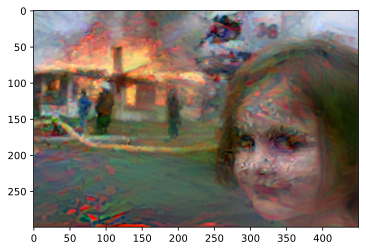

In [30]:
plt.imshow(postprocess(output))
plt.show()
postprocess(output).save("/content/drive/MyDrive/output_style_transfert.jpg")